Prepare paths and files for expansion

In [17]:
import os
import shutil

# Define paths
original_img_dir = 'Datasets/Flipped_v/img'
original_annotations_dir = 'Datasets/Flipped_v/annotations'
img_list_path = 'Datasets/Flipped_v/img_list_all.txt'

expanded_img_train_dir = 'Datasets/Expanded/train/images'
expanded_annotations_train_dir = 'Datasets/Expanded/train/labels'
expanded_img_val_dir = 'Datasets/Expanded/val/images'
expanded_annotations_val_dir = 'Datasets/Expanded/val/labels'

train_list_path = 'Datasets/Expanded/train_list.txt'
val_list_path = 'Datasets/Expanded/val_list.txt'

# Create directories if they do not exist
for directory in [expanded_img_train_dir, expanded_annotations_train_dir,
                  expanded_img_val_dir, expanded_annotations_val_dir]:
    os.makedirs(directory, exist_ok=True)

# Function to empty a directory
def empty_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Remove the directory and all its contents
    os.makedirs(directory)  # Recreate the directory

# Clear and create directories for training and validation sets
for directory in [expanded_img_train_dir, expanded_annotations_train_dir,
                  expanded_img_val_dir, expanded_annotations_val_dir]:
    empty_directory(directory)

# Empty the train and validation list files if they exist
open(train_list_path, 'w').close()
open(val_list_path, 'w').close()

Aug-definitions

In [15]:
def add_gaussian_noise(image, mean=0, sigma=None):
    """Add Gaussian noise to an image."""
    if sigma is None:
        sigma = random.uniform(5, 50)  # Random sigma between 5 and 50

    img_array = np.array(image).astype(float)
    gaussian_noise = np.random.normal(mean, sigma, img_array.shape)
    noisy_image = img_array + gaussian_noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return Image.fromarray(noisy_image)

def augment_image_mechanical(image, angle=0, blur=False, noise=False):
    """Apply mechanical augmentations."""
    if angle != 0:
        image = image.rotate(angle, expand=True)

    if blur:
        image = image.filter(ImageFilter.GaussianBlur(radius=1))

    if noise:
        image = add_gaussian_noise(image)  # Apply random Gaussian noise

    return image

def augment_image_natural(image, color_filter=None):
    """Apply natural augmentations."""
    if color_filter == 'sepia':
        img_array = np.array(image).astype(float)
        green_strength = (img_array[:,:,1] - np.maximum(img_array[:,:,0], img_array[:,:,2])) / 255.0
        green_mask = np.clip(green_strength, 0, 1)

        sepia_filter = np.array([
            [0.393, 0.769, 0.189],
            [0.349, 0.686, 0.168],
            [0.272, 0.534, 0.131]
        ])

        sepia_img = np.dot(img_array, sepia_filter.T)
        darkness_factor = random.uniform(0.2, 1.2)
        sepia_img *= darkness_factor

        green_mask = green_mask[:,:,np.newaxis]
        result = img_array * green_mask + sepia_img * (1 - green_mask)

        result = np.clip(result, 0, 255).astype(np.uint8)
        image = Image.fromarray(result.astype(np.uint8))

    elif color_filter == 'autumn':
        image = ImageEnhance.Color(image).enhance(1.2)

    elif color_filter == 'fog':
        img_array = np.array(image)

        # Create a white fog layer
        fog_layer = np.full_like(img_array, 255)

        # Create a uniform mask for the fog
        fog_strength = random.uniform(0.2, 0.4)
        mask = np.ones_like(img_array) * fog_strength

        # Apply the fog
        fogged = img_array * (1 - mask) + fog_layer * mask

        # Add milky blur
        blurred = cv2.GaussianBlur(fogged, (15, 15), 0)
        final_image = cv2.addWeighted(fogged, 0.7, blurred, 0.3, 0)

        image = Image.fromarray(final_image.astype(np.uint8))

    return image

def clip_bbox(bbox, img_width, img_height):
    """Clip bounding box coordinates to be within the image dimensions."""
    return [
        [max(0, min(bbox[0][0], img_width)), max(0, min(bbox[0][1], img_height))],
        [max(0, min(bbox[1][0], img_width)), max(0, min(bbox[1][1], img_height))]
    ]

def adjust_bboxes(bboxes, img_width, img_height, angle):
    """Adjust bounding boxes based on rotation angle."""
    if angle == 0:
        return [clip_bbox(bbox, img_width, img_height) for bbox in bboxes]

    rotated_bboxes = []
    for bbox in bboxes:
        x1, y1 = bbox[0]
        x2, y2 = bbox[1]

        if angle == 90:
            new_bbox = [[y1, img_width - x2], [y2, img_width - x1]]
        elif angle == 180:
            new_bbox = [[img_width - x2, img_height - y2], [img_width - x1, img_height - y1]]
        elif angle == 270:
            new_bbox = [[img_height - y2, x1], [img_height - y1, x2]]

        rotated_bboxes.append(clip_bbox(new_bbox, img_width, img_height))

    return rotated_bboxes

def convert_bbox_to_yolo_format(bbox, img_width, img_height):
    """Convert bounding box to YOLO format."""
    x_center = (bbox[0][0] + bbox[1][0]) / 2 / img_width
    y_center = (bbox[0][1] + bbox[1][1]) / 2 / img_height
    width = (bbox[1][0] - bbox[0][0]) / img_width
    height = (bbox[1][1] - bbox[0][1]) / img_height

    return x_center, y_center, width, height

def filter_small_bboxes(objects, min_size=5):
    """Filter out bounding boxes with width or height smaller than min_size."""
    filtered_objects = []
    for obj in objects:
        x1, y1 = obj['bbox'][0]
        x2, y2 = obj['bbox'][1]
        width = x2 - x1
        height = y2 - y1
        if width >= min_size and height >= min_size:
            filtered_objects.append(obj)
    return filtered_objects

Expansion of data

In [16]:
import shutil
import cv2
import json
import random
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np

# Load the original image list
with open(img_list_path, 'r') as file:
    image_pairs = [line.strip().split('\t') for line in file]

# Define a step for validation selection (e.g., every 3rd image)
step = 3  # Change this value to select every nth image

# Select original images for validation set based on the defined step
validation_images = [image_pairs[i] for i in range(len(image_pairs)) if (i + 1) % step == 0]

# Remove selected validation images from training pairs
training_images = [pair for pair in image_pairs if pair not in validation_images]

# Open train and validation list files
with open(train_list_path,"w") as train_list_file , open(val_list_path,"w") as val_list_file:

    # Process validation images (original only)
    for img_path, annot_path in validation_images:
        # Copy original image to validation directory
        shutil.copy(os.path.join(original_img_dir, os.path.basename(img_path)), expanded_img_val_dir)

        # Load original annotation
        with open(os.path.join(original_annotations_dir, os.path.basename(annot_path)), "r") as annot_file:
            annotation = json.load(annot_file)

        # Convert bounding boxes to YOLO format
        yolo_bboxes = []
        img_width, img_height = Image.open(os.path.join(original_img_dir, os.path.basename(img_path))).size

        for obj in annotation['objects']:
            if obj['label'] == 'sugarbeet':  # Only process specific labels if needed
                bbox_yolo_format = convert_bbox_to_yolo_format(obj['bbox'], img_width, img_height)
                class_id = 0  # Assuming class ID mapping
                yolo_bboxes.append(f"{class_id} {' '.join(map(str, bbox_yolo_format))}")

        # Save YOLO formatted annotations to validation directory
        aug_annot_name = f"{os.path.basename(annot_path).split('.')[0]}.txt"
        aug_annot_path = os.path.join(expanded_annotations_val_dir, aug_annot_name)

        with open(aug_annot_path, "w") as aug_annot_file:
            aug_annot_file.write("\n".join(yolo_bboxes))

        print(f"Copied {os.path.basename(img_path)} and converted annotations to YOLO format.")

    # Process training images (augmented)
    for img_path , annot_path in training_images:
        # Copy original image to train directory
        shutil.copy(os.path.join(original_img_dir, os.path.basename(img_path)), expanded_img_train_dir)

        # Load original annotation
        with open(os.path.join(original_annotations_dir, os.path.basename(annot_path)), "r") as annot_file:
            annotation = json.load(annot_file)

        # Convert bounding boxes to YOLO format
        yolo_bboxes = []
        img_width, img_height = Image.open(os.path.join(original_img_dir, os.path.basename(img_path))).size

        for obj in annotation['objects']:
            if obj['label'] == 'sugarbeet':  # Only process specific labels if needed
                bbox_yolo_format = convert_bbox_to_yolo_format(obj['bbox'], img_width, img_height)
                class_id = 0  # Assuming class ID mapping
                yolo_bboxes.append(f"{class_id} {' '.join(map(str, bbox_yolo_format))}")

        # Save YOLO formatted annotations to train directory
        aug_annot_name = f"{os.path.basename(annot_path).split('.')[0]}.txt"
        aug_annot_path = os.path.join(expanded_annotations_train_dir, aug_annot_name)

        with open(aug_annot_path, "w") as aug_annot_file:
            aug_annot_file.write("\n".join(yolo_bboxes))

        print(f"Copied {os.path.basename(img_path)} and converted annotations to YOLO format.")

        # Load the image and annotation
        image = Image.open(os.path.join(original_img_dir , os.path.basename(img_path)))

        with open(os.path.join(original_annotations_dir , os.path.basename(annot_path)), "r") as annot_file:
            annotation = json.load(annot_file)

        for i , obj in enumerate(annotation['objects']):
            if obj['label'] != 'sugarbeet':
                continue

            x1 , y1 = obj['bbox'][0]
            x2 , y2 = obj['bbox'][1]
            crop_x1 = max(0 , min(int(x1) - random.randint(0 , 320), image.width - 640))
            crop_y1 = max(0 , min(int(y1) - random.randint(0 , 320), image.height - 640))
            crop_x2 , crop_y2 = crop_x1 + 640 , crop_y1 + 640

            cropped_img = image.crop((crop_x1 , crop_y1 , crop_x2 , crop_y2))

            new_objects = []
            for j , other_obj in enumerate(annotation['objects']):
                ox1 , oy1 = other_obj['bbox'][0]
                ox2 , oy2 = other_obj['bbox'][1]
                if ox2 > crop_x1 and ox1 < crop_x2 and oy2 > crop_y1 and oy1 < crop_y2:
                    new_bbox = [[ox1 - crop_x1 , oy1 - crop_y1] , [ox2 - crop_x1 , oy2 - crop_y1]]
                    new_objects.append({"label": other_obj['label'] , "bbox": new_bbox})

            new_objects = filter_small_bboxes(new_objects)

            color_filter = random.choice([None, 'sepia', 'autumn', 'fog'])
            augmented_img_natural = augment_image_natural(cropped_img.copy() , color_filter=color_filter)

            angle = random.choice([0 , 90 , 180 , 270])
            blur = random.choice([True , False])
            noise = random.choice([True , False])

            augmented_img_mechanical = augment_image_mechanical(augmented_img_natural.copy() ,
                                                                angle=angle ,
                                                                blur=blur ,
                                                                noise=noise)

            # Save augmented image and annotation to training set
            aug_img_name = f"{os.path.basename(img_path).split('.')[0]}_crop_{i}_aug.png"
            aug_img_path = os.path.join(expanded_img_train_dir , aug_img_name)
            augmented_img_mechanical.save(aug_img_path)

            # Convert bounding boxes to YOLO format and save annotations
            img_width, img_height = augmented_img_mechanical.size

            # Adjust bounding boxes based on rotation angle before converting to YOLO format.
            adjusted_bboxes = adjust_bboxes([obj['bbox'] for obj in new_objects], img_width, img_height, angle)

            yolo_bboxes=[]
            for adjusted_bbox in adjusted_bboxes:
                class_id=0   # Assuming you have a mapping of labels to class IDs.
                bbox_yolo_format=convert_bbox_to_yolo_format(adjusted_bbox,img_width,img_height)
                yolo_bboxes.append(f"{class_id} {' '.join(map(str,bbox_yolo_format))}")

            aug_annot_name=f"{os.path.basename(img_path).split('.')[0]}_crop_{i}_aug.txt"
            aug_annot_path=os.path.join(expanded_annotations_train_dir , aug_annot_name)

            with open(aug_annot_path,"w") as aug_annot_file:
                aug_annot_file.write("\n".join(yolo_bboxes))

            # Register in the training list file
            train_list_file.write(f"img/{aug_img_name}\tannotations/{aug_annot_name}\n")

Copied sugarbeet_bbch12_000003_flipped_v.png and converted annotations to YOLO format.
Copied sugarbeet_bbch12_000006_flipped_v.png and converted annotations to YOLO format.
Copied sugarbeet_bbch12_000009_flipped_v.png and converted annotations to YOLO format.
Copied sugarbeet_bbch12_000012_flipped_v.png and converted annotations to YOLO format.
Copied sugarbeet_bbch12_000015_flipped_v.png and converted annotations to YOLO format.
Copied sugarbeet_bbch12_000018_flipped_v.png and converted annotations to YOLO format.
Copied sugarbeet_bbch12_000021_flipped_v.png and converted annotations to YOLO format.
Copied sugarbeet_bbch12_000024_flipped_v.png and converted annotations to YOLO format.
Copied sugarbeet_bbch12_000027_flipped_v.png and converted annotations to YOLO format.
Copied sugarbeet_bbch12_000030_flipped_v.png and converted annotations to YOLO format.
Copied sugarbeet_bbch12_000033_flipped_v.png and converted annotations to YOLO format.
Copied sugarbeet_bbch12_000036_flipped_v.pn

In [ ]:
# Function to draw bounding boxes on an image
def draw_bounding_boxes(image, bboxes):
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        # Convert YOLO format back to bounding box coordinates
        class_id, x_center, y_center, width, height = bbox
        img_width, img_height = image.size

        # Calculate coordinates
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)

        draw.rectangle([x1, y1, x2, y2], outline="yellow", width=3)
    return image

Image with bbox from set

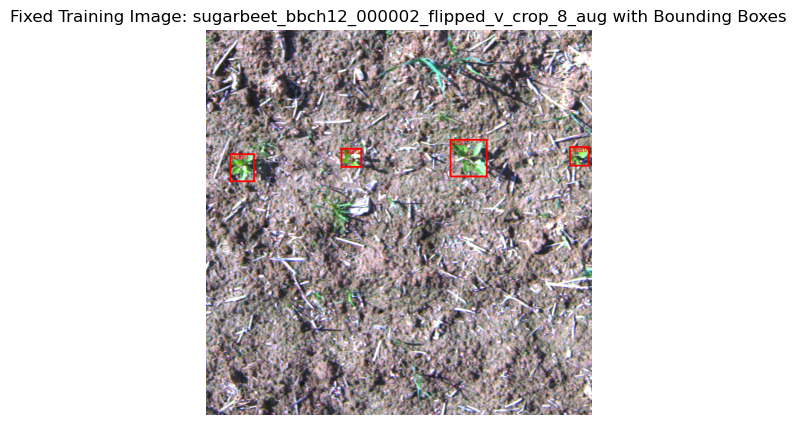

In [19]:
import os
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Paths to the training images and annotations
expanded_img_train_dir = 'Datasets/Expanded_15_flipped_v_th5/train/images'
expanded_annotations_train_dir = 'Datasets/Expanded_15_flipped_v_th5/train/labels'
train_list_path = 'Datasets/Expanded_15_flipped_v_th5/train_list.txt'

# Specify the fixed image name (without extension)
fixed_image_name = 'sugarbeet_bbch12_000002_flipped_v_crop_8_aug'  # Change this to your desired image name

# Construct paths for the fixed image and its annotation
img_path = os.path.join(expanded_img_train_dir, f"{fixed_image_name}.png")  # Adjust extension if needed
annot_path = os.path.join(expanded_annotations_train_dir, f"{fixed_image_name}.txt")  # Adjust extension if needed

# Load the image
image = Image.open(img_path)

# Load the annotations
with open(annot_path, 'r') as annot_file:
    annotation = [line.strip().split() for line in annot_file.readlines()]

# Convert bounding boxes from YOLO format to list of tuples for drawing
bboxes = [(int(obj[0]), float(obj[1]), float(obj[2]), float(obj[3]), float(obj[4])) for obj in annotation]

def draw_bounding_boxes(image, bboxes):
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        class_id, x_center, y_center, width, height = bbox
        # Convert YOLO format to pixel coordinates
        img_width, img_height = image.size
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)

        # Draw rectangle and label (optional)
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        draw.text((x1, y1), f'Class {class_id}', fill="red")

    return image

# Draw bounding boxes on the image
image_with_boxes = draw_bounding_boxes(image.copy(), bboxes)

# Display the image with bounding boxes and image name in title
plt.figure(figsize=(10, 5))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.title(f"Fixed Training Image: {fixed_image_name} with Bounding Boxes")
plt.show()


Data extension to learn on created base model

In [ ]:
import os
import shutil
import cv2
import random
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np

# Define paths
original_img_dir = 'Datasets/Original/Dataset_HSKempten_SmallCrops/train/images'
original_labels_dir = 'Datasets/Original/Dataset_HSKempten_SmallCrops/train/labels'

expanded_img_train_dir = 'Datasets/Expanded/train/images'
expanded_labels_train_dir = 'Datasets/Expanded/train/labels'

train_list_path = 'Datasets/Expanded/train_list.txt'

# Create directories if they do not exist
for directory in [expanded_img_train_dir, expanded_labels_train_dir]:
    os.makedirs(directory, exist_ok=True)

# Function to empty a directory
def empty_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

# Clear and create directories for training set
for directory in [expanded_img_train_dir, expanded_labels_train_dir]:
    empty_directory(directory)

# Empty the train list file if it exists
open(train_list_path, 'w').close()

def rotate_yolo_bbox(bbox, angle, img_width, img_height):
    """Rotate YOLO format bounding box."""
    x_center, y_center, width, height = bbox
    if angle == 90:
        return [1 - y_center, x_center, height, width]
    elif angle == 180:
        return [1 - x_center, 1 - y_center, width, height]
    elif angle == 270:
        return [y_center, 1 - x_center, height, width]
    return bbox

def filter_small_bboxes(objects, min_size=15):
    """Filter out bounding boxes with width or height smaller than min_size."""
    filtered_objects = []
    for obj in objects:
        width = obj[3] * 640  # YOLO format width to pixel width
        height = obj[4] * 640  # YOLO format height to pixel height
        if width >= min_size and height >= min_size:
            filtered_objects.append(obj)
    return filtered_objects

def process_and_augment_image(img_path, label_path):
    # Load the image and label
    image = Image.open(img_path)
    img_width, img_height = image.size

    with open(label_path, 'r') as label_file:
        original_labels = [list(map(float, line.strip().split())) for line in label_file]

    augmented_images = []
    augmented_labels_list = []

    for i, obj in enumerate(original_labels):
        class_id, x_center, y_center, width, height = obj

        # Convert YOLO format to pixel coordinates
        x1 = int((x_center - width/2) * img_width)
        y1 = int((y_center - height/2) * img_height)

        # Create crop coordinates
        crop_x1 = max(0, min(x1 - random.randint(0, 320), img_width - 640))
        crop_y1 = max(0, min(y1 - random.randint(0, 320), img_height - 640))
        crop_x2, crop_y2 = crop_x1 + 640, crop_y1 + 640

        cropped_img = image.crop((crop_x1, crop_y1, crop_x2, crop_y2))

        # Adjust labels for the crop
        new_labels = []
        for label in original_labels:
            class_id, x_center, y_center, width, height = label
            x_center = (x_center * img_width - crop_x1) / 640
            y_center = (y_center * img_height - crop_y1) / 640
            width = (width * img_width) / 640
            height = (height * img_height) / 640

            if 0 < x_center < 1 and 0 < y_center < 1:
                new_labels.append([class_id, x_center, y_center, width, height])

        new_labels = filter_small_bboxes(new_labels)

        if new_labels:
            # Apply augmentations
            color_filter = random.choice([None, 'sepia', 'autumn', 'fog'])
            augmented_img_natural = augment_image_natural(cropped_img.copy(), color_filter=color_filter)

            angle = random.choice([0, 90, 180, 270])
            blur = random.choice([True, False])
            noise = random.choice([True, False])

            augmented_img_mechanical = augment_image_mechanical(augmented_img_natural.copy(),
                                                                angle=angle,
                                                                blur=blur,
                                                                noise=noise)

            # Rotate labels if necessary
            rotated_labels = []
            for label in new_labels:
                class_id, *bbox = label
                rotated_bbox = rotate_yolo_bbox(bbox, angle, 640, 640)
                rotated_labels.append([int(class_id)] + rotated_bbox)

            augmented_images.append(augmented_img_mechanical)
            augmented_labels_list.append(rotated_labels)

    return augmented_images, augmented_labels_list

# Process images
image_files = [f for f in os.listdir(original_img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

with open(train_list_path, "w") as train_list_file:
    for img_file in image_files:
        img_path = os.path.join(original_img_dir, img_file)
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(original_labels_dir, label_file)

        if not os.path.exists(label_path):
            print(f"Warning: No label file found for {img_file}. Skipping.")
            continue

        # Create augmented versions
        augmented_images, augmented_labels_list = process_and_augment_image(img_path, label_path)

        for i, (aug_img, aug_labels) in enumerate(zip(augmented_images, augmented_labels_list)):
            # Save augmented image and labels
            aug_img_name = f"{os.path.splitext(img_file)[0]}_aug_{i}.png"
            aug_img_path = os.path.join(expanded_img_train_dir, aug_img_name)
            aug_img.save(aug_img_path)

            aug_label_name = f"{os.path.splitext(img_file)[0]}_aug_{i}.txt"
            aug_label_path = os.path.join(expanded_labels_train_dir, aug_label_name)
            with open(aug_label_path, "w") as aug_label_file:
                for label in aug_labels:
                    aug_label_file.write(f"{' '.join(map(str, label))}\n")

            # Register augmented version in the training list file
            train_list_file.write(f"images/{aug_img_name}\tlabels/{aug_label_name}\n")

        print(f"Processed and augmented {img_file}")

print("Dataset expansion completed.")


Create mixed Dataset

In [ ]:
import os
import shutil
import random

def create_mixed_dataset(original_dataset, small_crops_dataset, output_dataset, mix_ratio=0.5):
    """
    Create a mixed dataset from the original expanded dataset and the small crops dataset.

    :param original_dataset: Path to the original expanded dataset
    :param small_crops_dataset: Path to the small crops dataset
    :param output_dataset: Path to save the mixed dataset
    :param mix_ratio: Ratio of small crops to include (0.5 means 50% small crops, 50% original)
    """

    # Create output directories
    os.makedirs(os.path.join(output_dataset, 'train', 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dataset, 'train', 'labels'), exist_ok=True)
    os.makedirs(os.path.join(output_dataset, 'val', 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dataset, 'val', 'labels'), exist_ok=True)

    # Function to copy files
    def copy_files(src_list, src_dir, dst_dir, is_small_crop):
        for line in src_list:
            img_path, label_path = line.strip().split('\t')
            img_name = os.path.basename(img_path)
            label_name = os.path.basename(label_path)

            if is_small_crop:
                prefix = 'small_'
            else:
                prefix = ''

            # Construct full paths based on your folder structure
            full_img_path = os.path.join(src_dir, img_path)  # This assumes img_path starts with 'images/'
            full_label_path = os.path.join(src_dir, label_path)  # This assumes label_path starts with 'labels/'

            if not os.path.exists(full_img_path):
                print(f"Warning: Image file not found: {full_img_path}")
                continue

            if not os.path.exists(full_label_path):
                print(f"Warning: Label file not found: {full_label_path}")
                continue

            try:
                shutil.copy(full_img_path,
                            os.path.join(dst_dir, 'images', f"{prefix}{img_name}"))
                shutil.copy(full_label_path,
                            os.path.join(dst_dir, 'labels', f"{prefix}{label_name}"))
            except Exception as e:
                print(f"Error copying files: {e}")
                print(f"Source image: {full_img_path}")
                print(f"Source label: {full_label_path}")

    # Process training data
    with open(os.path.join(original_dataset, 'train_list.txt'), 'r') as f:
        original_train = f.readlines()
    with open(os.path.join(small_crops_dataset, 'train_list.txt'), 'r') as f:
        small_crops_train = f.readlines()

    # Determine number of small crops to include
    num_small_crops = int(len(original_train) * mix_ratio / (1 - mix_ratio))
    small_crops_train = random.sample(small_crops_train, min(num_small_crops, len(small_crops_train)))

    # Copy files
    copy_files(original_train, os.path.join(original_dataset, 'train'), os.path.join(output_dataset, 'train'), False)
    copy_files(small_crops_train, os.path.join(small_crops_dataset, 'train'), os.path.join(output_dataset, 'train'), True)

    # Process validation data
    original_val_path = os.path.join(original_dataset, 'val_list.txt')
    small_crops_val_path = os.path.join(small_crops_dataset, 'val_list.txt')

    if not os.path.exists(original_val_path):
        print(f"Warning: Original validation list not found at {original_val_path}")
        original_val = []
    else:
        with open(original_val_path, 'r') as f:
            original_val = f.readlines()
        print(f"Found {len(original_val)} entries in original validation list")

    if not os.path.exists(small_crops_val_path):
        print(f"Warning: Small crops validation list not found at {small_crops_val_path}")
        small_crops_val = []
    else:
        with open(small_crops_val_path, 'r') as f:
            small_crops_val = f.readlines()
        print(f"Found {len(small_crops_val)} entries in small crops validation list")

    if not original_val and not small_crops_val:
        print("Error: Both validation lists are empty or not found. No validation data will be copied.")
        return

    # Determine number of small crops to include in validation
    num_small_crops_val = int(len(original_val) * mix_ratio / (1 - mix_ratio))
    small_crops_val = random.sample(small_crops_val, min(num_small_crops_val, len(small_crops_val)))

    # Copy files
    if original_val:
        print("Copying original validation files...")
        copy_files(original_val, os.path.join(original_dataset, 'val'), os.path.join(output_dataset, 'val'), False)
    if small_crops_val:
        print("Copying small crops validation files...")
        copy_files(small_crops_val, os.path.join(small_crops_dataset, 'val'), os.path.join(output_dataset, 'val'), True)

    # Create new train_list.txt and val_list.txt
    def create_list_file(output_dir):
        images = os.listdir(os.path.join(output_dir, 'images'))
        list_file_path = os.path.join(output_dir, f'list.txt')
        with open(list_file_path, 'w') as f:
            for img in images:
                label = img.replace('.png', '.txt').replace('.jpg', '.txt')
                f.write(f"images/{img}\tlabels/{label}\n")
        print(f"Created list file at {list_file_path} with {len(images)} entries")

    create_list_file(os.path.join(output_dataset, 'train'))
    create_list_file(os.path.join(output_dataset, 'val'))

    print("Mixed dataset created successfully.")

# Usage example
create_mixed_dataset(
    original_dataset='Datasets/Expanded_3',
    small_crops_dataset='Datasets/Expanded_5',
    output_dataset='Datasets/Expanded',
    mix_ratio=0.4  # 30% small crops, 70% original
)

Fix lists

In [ ]:
import os

def update_list_file(file_path):
    # Read the original file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Process and update each line
    updated_lines = []
    for line in lines:
        # Split the line into image path and label path
        img_path, label_path = line.strip().split('\t')

        # Update the paths
        img_path = img_path.replace('img/', 'images/')
        label_path = label_path.replace('annotations/', 'labels/')

        # Combine the updated paths
        updated_line = f"{img_path}\t{label_path}\n"
        updated_lines.append(updated_line)

    # Write the updated content back to the file
    with open(file_path, 'w') as file:
        file.writelines(updated_lines)

    print(f"Updated {file_path}")

# Paths to your list files
train_list_path = 'Datasets/Expanded_3/train_list.txt'
val_list_path = 'Datasets/Expanded_3/val_list.txt'

# Update both files
update_list_file(train_list_path)
update_list_file(val_list_path)

# Flip images horizontally

In [ ]:
def flip_images_and_labels(original_img_dir, original_annotations_dir, flipped_img_dir, flipped_annotations_dir):
    """
    Flip all images in original_img_dir and their corresponding labels,
    saving them to flipped_img_dir and flipped_annotations_dir respectively.
    """
    import os
    from PIL import Image
    import json

    # Ensure output directories exist
    os.makedirs(flipped_img_dir, exist_ok=True)
    os.makedirs(flipped_annotations_dir, exist_ok=True)

    for img_name in os.listdir(original_img_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Flip image
            img_path = os.path.join(original_img_dir, img_name)
            img = Image.open(img_path)
            flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)

            # Save flipped image
            flipped_img_name = f"{os.path.splitext(img_name)[0]}_flipped{os.path.splitext(img_name)[1]}"
            flipped_img_path = os.path.join(flipped_img_dir, flipped_img_name)
            flipped_img.save(flipped_img_path)

            # Flip labels
            json_name = f"{os.path.splitext(img_name)[0]}.json"
            json_path = os.path.join(original_annotations_dir, json_name)

            if os.path.exists(json_path):
                with open(json_path, 'r') as f:
                    annotation = json.load(f)

                img_width = annotation.get('image_width', img.width)

                for obj in annotation['objects']:
                    x1, y1 = obj['bbox'][0]
                    x2, y2 = obj['bbox'][1]
                    obj['bbox'] = [[img_width - x2, y1], [img_width - x1, y2]]

                # Save flipped labels
                flipped_json_name = f"{os.path.splitext(img_name)[0]}_flipped.json"
                flipped_json_path = os.path.join(flipped_annotations_dir, flipped_json_name)

                with open(flipped_json_path, 'w') as f:
                    json.dump(annotation, f, indent=4)

            print(f"Processed: {img_name}")

    print("Flipping completed.")

# Usage
flip_images_and_labels(
    original_img_dir,
    original_annotations_dir,
    os.path.join(expanded_img_train_dir, 'flipped'),
    os.path.join(expanded_annotations_train_dir, 'flipped')
)

# Flip images vertically

In [7]:
def flip_images_and_labels(original_img_dir, original_annotations_dir, flipped_img_dir, flipped_annotations_dir):
    """
    Flip all images in original_img_dir vertically and their corresponding labels,
    saving them to flipped_img_dir and flipped_annotations_dir respectively.
    """
    import os
    from PIL import Image
    import json

    # Ensure output directories exist
    os.makedirs(flipped_img_dir, exist_ok=True)
    os.makedirs(flipped_annotations_dir, exist_ok=True)

    for img_name in os.listdir(original_img_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Flip image vertically
            img_path = os.path.join(original_img_dir, img_name)
            img = Image.open(img_path)
            flipped_img = img.transpose(Image.FLIP_TOP_BOTTOM)

            # Save flipped image
            flipped_img_name = f"{os.path.splitext(img_name)[0]}_flipped_v{os.path.splitext(img_name)[1]}"
            flipped_img_path = os.path.join(flipped_img_dir, flipped_img_name)
            flipped_img.save(flipped_img_path)

            # Flip labels
            json_name = f"{os.path.splitext(img_name)[0]}.json"
            json_path = os.path.join(original_annotations_dir, json_name)

            if os.path.exists(json_path):
                with open(json_path, 'r') as f:
                    annotation = json.load(f)

                img_height = annotation.get('image_height', img.height)

                for obj in annotation['objects']:
                    x1, y1 = obj['bbox'][0]
                    x2, y2 = obj['bbox'][1]
                    obj['bbox'] = [[x1, img_height - y2], [x2, img_height - y1]]

                # Save flipped labels
                flipped_json_name = f"{os.path.splitext(img_name)[0]}_flipped_v.json"
                flipped_json_path = os.path.join(flipped_annotations_dir, flipped_json_name)

                with open(flipped_json_path, 'w') as f:
                    json.dump(annotation, f, indent=4)

            print(f"Processed: {img_name}")

    print("Flipping completed.")

# Usage
flip_images_and_labels(
    original_img_dir,
    original_annotations_dir,
    os.path.join(expanded_img_train_dir, 'flipped_v'),
    os.path.join(expanded_annotations_train_dir, 'flipped_v')
)


Processed: sugarbeet_bbch12_000001.png
Processed: sugarbeet_bbch12_000002.png
Processed: sugarbeet_bbch12_000003.png
Processed: sugarbeet_bbch12_000004.png
Processed: sugarbeet_bbch12_000005.png
Processed: sugarbeet_bbch12_000006.png
Processed: sugarbeet_bbch12_000007.png
Processed: sugarbeet_bbch12_000008.png
Processed: sugarbeet_bbch12_000009.png
Processed: sugarbeet_bbch12_000010.png
Processed: sugarbeet_bbch12_000011.png
Processed: sugarbeet_bbch12_000012.png
Processed: sugarbeet_bbch12_000013.png
Processed: sugarbeet_bbch12_000014.png
Processed: sugarbeet_bbch12_000015.png
Processed: sugarbeet_bbch12_000016.png
Processed: sugarbeet_bbch12_000017.png
Processed: sugarbeet_bbch12_000018.png
Processed: sugarbeet_bbch12_000019.png
Processed: sugarbeet_bbch12_000020.png
Processed: sugarbeet_bbch12_000021.png
Processed: sugarbeet_bbch12_000022.png
Processed: sugarbeet_bbch12_000023.png
Processed: sugarbeet_bbch12_000024.png
Processed: sugarbeet_bbch12_000025.png
Processed: sugarbeet_bbch

In [8]:
import os

def create_img_annotation_list(original_img_dir, original_annotations_dir, img_list_path):
    """
    Creates a text file containing pairings of image files and their corresponding annotation files.

    Args:
        original_img_dir (str): Directory containing the image files.
        original_annotations_dir (str): Directory containing the annotation files.
        img_list_path (str): Path to save the output text file.
    """
    with open(img_list_path, 'w') as file:
        for img_name in sorted(os.listdir(original_img_dir)):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(original_img_dir, img_name)
                annotation_name = f"{os.path.splitext(img_name)[0]}.json"
                annotation_path = os.path.join(original_annotations_dir, annotation_name)

                if os.path.exists(annotation_path):
                    # Write the pairing to the txt file
                    relative_img_path = os.path.relpath(img_path, start=os.path.dirname(img_list_path))
                    relative_annotation_path = os.path.relpath(annotation_path, start=os.path.dirname(img_list_path))
                    file.write(f"{relative_img_path}\t{relative_annotation_path}\n")
                else:
                    print(f"Warning: No annotation found for {img_name}")

    print(f"Image-annotation list saved to {img_list_path}")

# Usage
create_img_annotation_list(
    original_img_dir='Datasets/Flipped_v/img',
    original_annotations_dir='Datasets/Flipped_v/annotations',
    img_list_path='Datasets/Flipped_v/img_list_all.txt'
)

Image-annotation list saved to Datasets/Flipped_v/img_list_all.txt


In [18]:
import os
import shutil

def combine_datasets(dataset1_path, dataset2_path, output_path):
    """
    Combines training and validation data from two datasets.

    :param dataset1_path: Path to the first dataset's Expanded folder
    :param dataset2_path: Path to the second dataset's Expanded folder
    :param output_path: Path where the combined dataset will be saved
    """
    # Create output directories
    os.makedirs(os.path.join(output_path, 'train', 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'train', 'labels'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'val', 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'val', 'labels'), exist_ok=True)

    # Combine data from both datasets
    for dataset_path in [dataset1_path, dataset2_path]:
        # Copy training images and labels
        for folder in ['images', 'labels']:
            src_train = os.path.join(dataset_path, 'train', folder)
            dst_train = os.path.join(output_path, 'train', folder)
            for file in os.listdir(src_train):
                shutil.copy(os.path.join(src_train, file), dst_train)

        # Copy validation images and labels
        for folder in ['images', 'labels']:
            src_val = os.path.join(dataset_path, 'val', folder)
            dst_val = os.path.join(output_path, 'val', folder)
            for file in os.listdir(src_val):
                shutil.copy(os.path.join(src_val, file), dst_val)

    # Combine train_list.txt files
    with open(os.path.join(output_path, 'train_list.txt'), 'w') as outfile:
        for dataset_path in [dataset1_path, dataset2_path]:
            with open(os.path.join(dataset_path, 'train_list.txt'), 'r') as infile:
                outfile.write(infile.read())

    # Combine val_list.txt files
    with open(os.path.join(output_path, 'val_list.txt'), 'w') as outfile:
        for dataset_path in [dataset1_path, dataset2_path]:
            with open(os.path.join(dataset_path, 'val_list.txt'), 'r') as infile:
                outfile.write(infile.read())

    print("Datasets combined successfully!")

# Usage
combine_datasets('Datasets/Expanded_14_comb11_12_13', 'Datasets/Expanded_15_flipped_v_th5', 'Datasets/Expanded')

Datasets combined successfully!


In [ ]:
import os
import shutil

def rename_and_move_files(source_dir, dest_dir, file_type):
    os.makedirs(dest_dir, exist_ok=True)
    for filename in os.listdir(source_dir):
        if filename.endswith(file_type):
            new_filename = filename.replace('_crop_', '_small_crop_')
            shutil.copy2(os.path.join(source_dir, filename), os.path.join(dest_dir, new_filename))

def append_train_list(source_file, dest_file):
    with open(source_file, 'r') as src, open(dest_file, 'a') as dest:
        for line in src:
            new_line = line.replace('_crop_', '_small_crop_')
            dest.write(new_line)

# Define paths
source_image_dir = 'Datasets/Expanded_13_small_th5/train/images'
source_label_dir = 'Datasets/Expanded_13_small_th5/train/labels'
dest_image_dir = 'Datasets/Expanded_14_comb11_12_13/train/images'
dest_label_dir = 'Datasets/Expanded_14_comb11_12_13/train/labels'
source_train_list = 'Datasets/Expanded_13_small_th5/train_list.txt'
dest_train_list = 'Datasets/Expanded_14_comb11_12_13/train_list.txt'

# Rename and move image files
rename_and_move_files(source_image_dir, dest_image_dir, '.png')

# Rename and move label files
rename_and_move_files(source_label_dir, dest_label_dir, '.txt')

# Append and modify train_list.txt
append_train_list(source_train_list, dest_train_list)

print("Process completed successfully.")